In [1]:
!pip install faiss-cpu
import faiss

!pip install timm

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import timm
import matplotlib.pyplot as plt
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

cifar100_train = torchvision.datasets.CIFAR100(root='./data', train=True,
                                               download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(cifar100_train, batch_size=64, shuffle=False)

100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


In [3]:
# Step 2: Load ResNet-18 model
from torchvision.models import resnet18

model_name = 'resnet18'
model = resnet18(pretrained=True)
model.fc = torch.nn.Identity()  # Remove classification head
model.eval()

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


In [4]:
model = model.to(device)
example_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    out_dim = model(example_input).shape[1]

features = np.empty((0, out_dim), dtype='float32')
labels = []

for images, targets in tqdm(train_loader, desc=f"Extracting features with {model_name}"):
    images = images.to(device)
    with torch.no_grad():
        feats = model(images).cpu().numpy().astype('float32')
    features = np.vstack((features, feats))
    labels.extend(targets.numpy())

faiss.normalize_L2(features)
index = faiss.IndexFlatIP(features.shape[1])
index.add(features)

Extracting features with resnet18: 100%|██████████| 782/782 [02:34<00:00,  5.05it/s]


In [5]:
# Step 4: Define retrieval functions
def retrieve_similar_images_faiss(query_features, faiss_index, k=10):
    faiss.normalize_L2(query_features)
    D, I = faiss_index.search(query_features, k)
    return I[0], D[0]


In [6]:
def visualize_retrieval(query_idx, retrieved_indices, dataset, title="FAISS Retrieval", k=10, class_names=None):
    query_img, query_label = dataset[query_idx]
    fig, axes = plt.subplots(1, k + 1, figsize=(15, 5))
    axes[0].imshow((query_img.permute(1, 2, 0).numpy() * 0.5 + 0.5))
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, idx in enumerate(retrieved_indices):
        retrieved_img, label = dataset[idx]
        img = retrieved_img.permute(1, 2, 0).numpy() * 0.5 + 0.5
        axes[i+1].imshow(img)
        axes[i+1].set_title(f"Top-{i+1}" if class_names is None else class_names[label])
        axes[i+1].axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


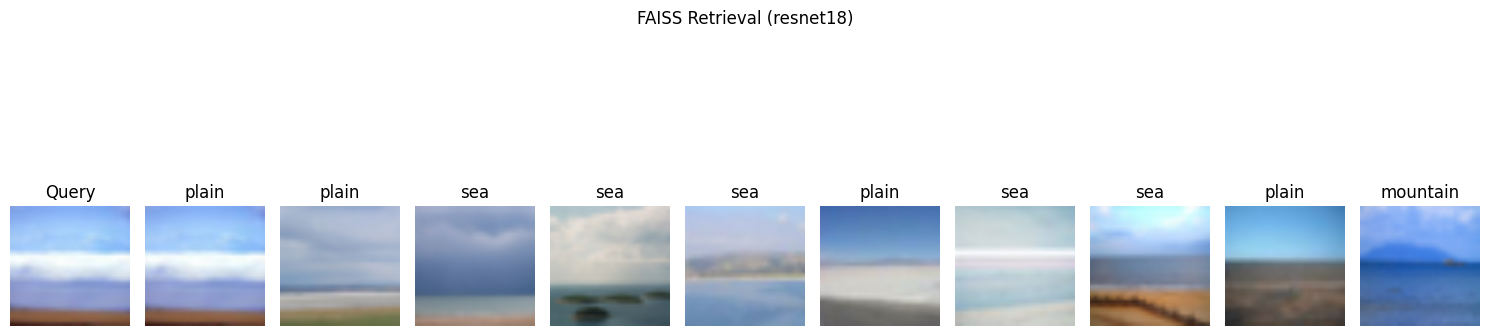

Precision@10: 0.40
False Positive Rate@10: 0.60


In [7]:
# Step 6: Retrieve and display similar images using a custom snippet
if __name__ == '__main__':
    faiss_index = index
    dataset = cifar100_train

    # Select a random query image
    query_idx = 300  # customised index
    query_image, query_label = dataset[query_idx]
    query_image_tensor = query_image.unsqueeze(0).to(device)
    with torch.no_grad():
        query_features = model(query_image_tensor).cpu().numpy().astype('float32')

    # Retrieve similar images
    k = 10  # Number of top matches to retrieve
    faiss_indices, _ = retrieve_similar_images_faiss(query_features, faiss_index, k=k)

    # Visualize retrieval results
    class_names = dataset.classes
    visualize_retrieval(query_idx, faiss_indices, dataset, title=f"FAISS Retrieval ({model_name})", k=k, class_names=class_names)

    # Step 7: Compute Precision@k and FPR@k
    correct = 0
    for idx in faiss_indices:
        _, label = dataset[idx]
        if label == query_label:
            correct += 1

    false_positives = k - correct
    precision_at_k = correct / k
    fpr_at_k = false_positives / k if k != correct else 0.0

    print(f"Precision@{k}: {precision_at_k:.2f}")
    print(f"False Positive Rate@{k}: {fpr_at_k:.2f}")
